In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/heart_disease_health_indicators_BRFSS2015.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())

Dataset Shape: (253680, 22)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth  

Missing values: 0

Target variable distribution:
HeartDiseaseorAttack
0.0    229787
1.0     23893
Name: count, dtype: int64

Percentage of heart disease cases: 9.42%


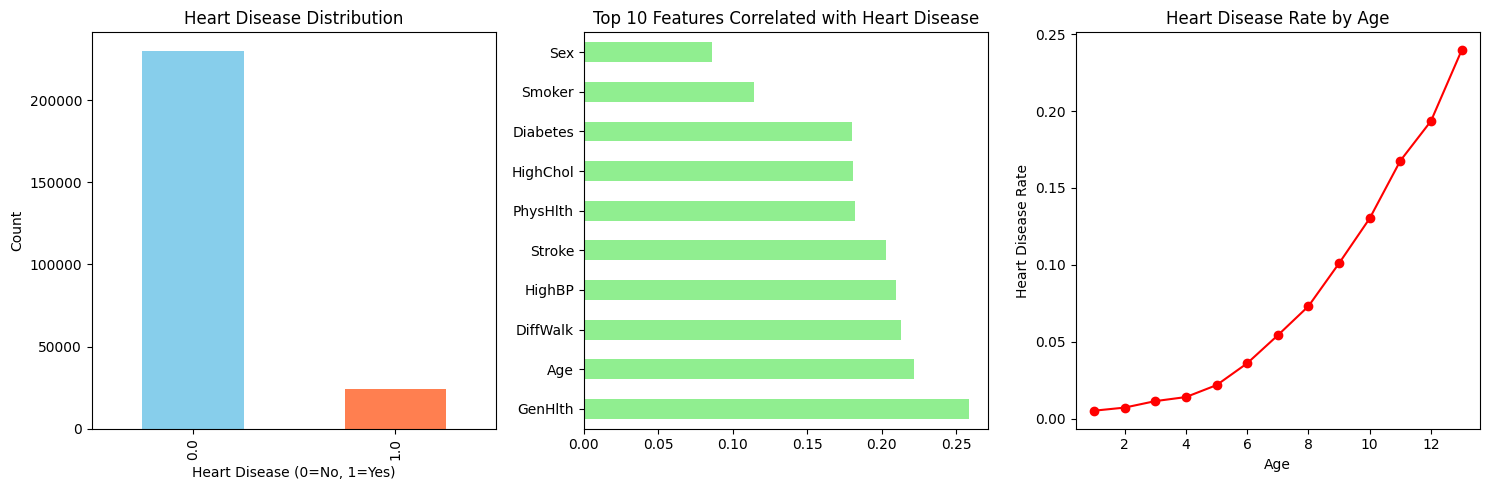

In [3]:
# Check for missing values and basic statistics
print("Missing values:", df.isnull().sum().sum())
print("\nTarget variable distribution:")
print(df['HeartDiseaseorAttack'].value_counts())
print("\nPercentage of heart disease cases: {:.2f}%".format(df['HeartDiseaseorAttack'].mean() * 100))

# Visualize target distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['HeartDiseaseorAttack'].value_counts().plot(kind='bar', color=['skyblue', 'coral'])
plt.title('Heart Disease Distribution')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Count')

# Correlation with target
plt.subplot(1, 3, 2)
correlations = df.corr()['HeartDiseaseorAttack'].sort_values(ascending=False)[1:11]
correlations.plot(kind='barh', color='lightgreen')
plt.title('Top 10 Features Correlated with Heart Disease')

# Age vs Heart Disease
plt.subplot(1, 3, 3)
df.groupby('Age')['HeartDiseaseorAttack'].mean().plot(kind='line', color='red', marker='o')
plt.title('Heart Disease Rate by Age')
plt.xlabel('Age')
plt.ylabel('Heart Disease Rate')

plt.tight_layout()
plt.show()

In [6]:
# Create feature groups for better analysis
lifestyle_features = ['PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'Smoker']
medical_history = ['HighBP', 'HighChol', 'Stroke', 'Diabetes', 'DiffWalk']
demographic_features = ['Age', 'Education', 'Income']

# Create some interaction features that might be medically relevant
# Convert 'HighBP' and 'HighChol' to integer types before performing bitwise operations
df['BP_Chol'] = df['HighBP'].astype(int) & df['HighChol'].astype(int)
df['Diabetes_Age'] = df['Diabetes'] * df['Age']
df['MultipleRiskFactors'] = df['HighBP'] + df['HighChol'] + df['Smoker']

# Prepare features and target
X = df.drop('HeartDiseaseorAttack', axis=1)
y = df['HeartDiseaseorAttack']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Positive cases in training: {y_train.mean():.3f}")
print(f"Positive cases in test: {y_test.mean():.3f}")

Training set size: (202944, 24)
Test set size: (50736, 24)
Positive cases in training: 0.094
Positive cases in test: 0.094


In [7]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set scaled shape:", X_train_scaled.shape)
print("Test set scaled shape:", X_test_scaled.shape)

Training set scaled shape: (202944, 24)
Test set scaled shape: (50736, 24)


In [8]:
# Initialize models with class weights to handle imbalance
models = {
    'XGBoost': XGBClassifier(
        random_state=42,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        eval_metric='logloss'
    ),
    'LightGBM': LGBMClassifier(
        random_state=42,
        class_weight='balanced',
        verbose=-1
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        random_state=42,
        class_weight='balanced',
        max_iter=1000,
        n_jobs=-1
    )
}

# Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    accuracy = model.score(X_test, y_test)
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    # Store results
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc_roc': auc_roc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Training XGBoost...
XGBoost Results:
Accuracy: 0.7521
AUC-ROC: 0.8421

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     45957
         1.0       0.24      0.78      0.37      4779

    accuracy                           0.75     50736
   macro avg       0.61      0.77      0.61     50736
weighted avg       0.90      0.75      0.80     50736


Training LightGBM...
LightGBM Results:
Accuracy: 0.7400
AUC-ROC: 0.8496

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.73      0.84     45957
         1.0       0.24      0.81      0.37      4779

    accuracy                           0.74     50736
   macro avg       0.61      0.77      0.60     50736
weighted avg       0.91      0.74      0.79     50736


Training Random Forest...
Random Forest Results:
Accuracy: 0.8995
AUC-ROC: 0.8135

Classification Report:
              precision    recall  f1-score   s

In [9]:
# Hyperparameter tuning for XGBoost
print("Performing hyperparameter tuning for XGBoost...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    eval_metric='logloss'
)

# Use randomized search for faster tuning
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    xgb,
    param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best CV score: {:.4f}".format(random_search.best_score_))

# Train final model with best parameters
best_xgb = random_search.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

final_accuracy = best_xgb.score(X_test, y_test)
final_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"\nFinal XGBoost Performance:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"AUC-ROC: {final_auc:.4f}")

Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV score: 0.8497

Final XGBoost Performance:
Accuracy: 0.7405
AUC-ROC: 0.8503


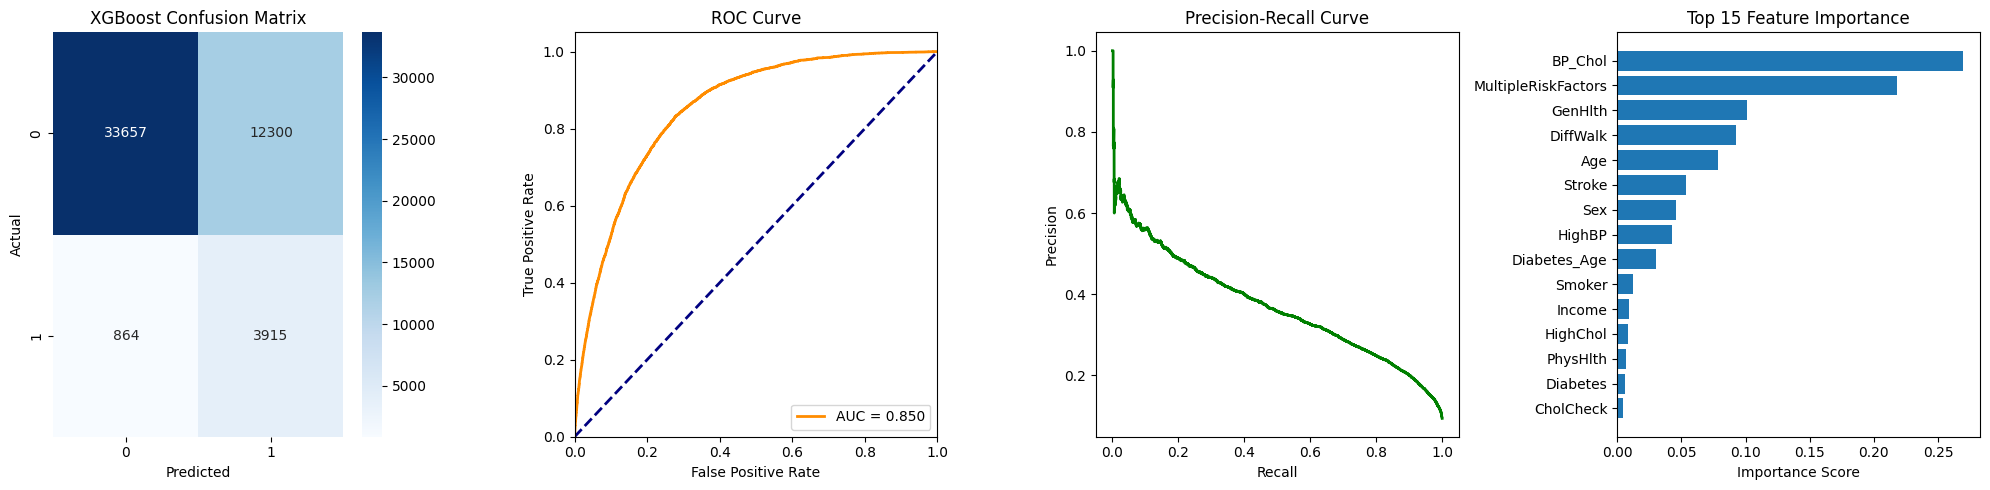

In [10]:
# Create comprehensive evaluation plots
plt.figure(figsize=(20, 5))

# 1. Confusion Matrix
plt.subplot(1, 4, 1)
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 2. ROC Curve
plt.subplot(1, 4, 2)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {final_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# 3. Precision-Recall Curve
plt.subplot(1, 4, 3)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
plt.plot(recall, precision, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# 4. Feature Importance
plt.subplot(1, 4, 4)
feature_importance = best_xgb.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=True).tail(15)

plt.barh(importance_df['feature'], importance_df['importance'])
plt.title('Top 15 Feature Importance')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()


Model Comparison:
                 Model  Accuracy   AUC-ROC
4      XGBoost (Tuned)  0.740539  0.850337
1             LightGBM  0.740027  0.849629
3  Logistic Regression  0.752996  0.847117
0              XGBoost  0.752148  0.842051
2        Random Forest  0.899460  0.813512


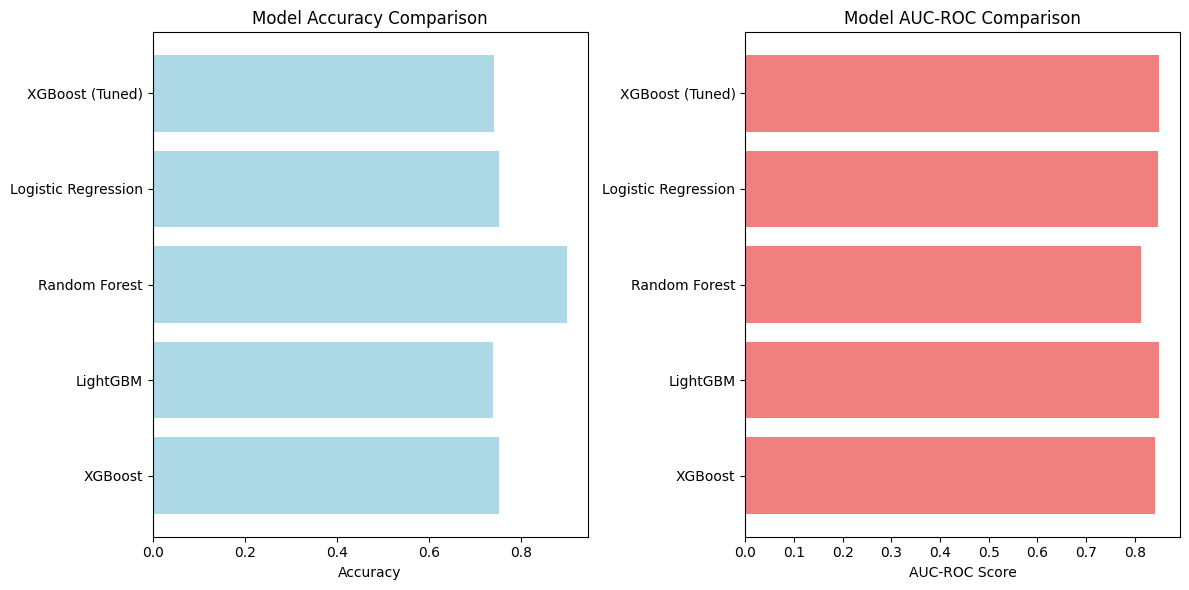

In [11]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'AUC-ROC': [results[name]['auc_roc'] for name in results.keys()]
})

# Add tuned XGBoost
comparison_df = pd.concat([
    comparison_df,
    pd.DataFrame({
        'Model': ['XGBoost (Tuned)'],
        'Accuracy': [final_accuracy],
        'AUC-ROC': [final_auc]
    })
], ignore_index=True)

print("\nModel Comparison:")
print(comparison_df.sort_values('AUC-ROC', ascending=False))

# Plot comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.barh(comparison_df['Model'], comparison_df['Accuracy'], color='lightblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Accuracy')

plt.subplot(1, 2, 2)
plt.barh(comparison_df['Model'], comparison_df['AUC-ROC'], color='lightcoral')
plt.title('Model AUC-ROC Comparison')
plt.xlabel('AUC-ROC Score')

plt.tight_layout()
plt.show()

In [12]:
def predict_heart_disease_risk(model, input_data, feature_names):
    """
    Predict heart disease risk for new patients
    """
    # Create DataFrame with same features as training
    input_df = pd.DataFrame([input_data], columns=feature_names)

    # Get prediction and probability
    prediction = model.predict(input_df)[0]
    probability = model.predict_proba(input_df)[0][1]

    risk_level = "High Risk" if probability > 0.7 else "Medium Risk" if probability > 0.3 else "Low Risk"

    return {
        'prediction': 'Heart Disease' if prediction == 1 else 'No Heart Disease',
        'probability': probability,
        'risk_level': risk_level
    }

# Example usage with a new patient
new_patient = {
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 30, 'Smoker': 1,
    'Stroke': 0, 'Diabetes': 1, 'PhysActivity': 0, 'Fruits': 0, 'Veggies': 0,
    'HvyAlcoholConsump': 0, 'AnyHealthcare': 1, 'NoDocbcCost': 0, 'GenHlth': 4,
    'MentHlth': 10, 'PhysHlth': 15, 'DiffWalk': 1, 'Sex': 1, 'Age': 9,
    'Education': 3, 'Income': 4, 'BP_Chol': 1, 'Diabetes_Age': 9, 'MultipleRiskFactors': 3
}

risk_assessment = predict_heart_disease_risk(best_xgb, list(new_patient.values()), X.columns)
print("\nPatient Risk Assessment:")
for key, value in risk_assessment.items():
    print(f"{key}: {value}")


Patient Risk Assessment:
prediction: Heart Disease
probability: 0.8595232963562012
risk_level: High Risk


In [13]:
print("\n" + "="*60)
print("KEY INSIGHTS AND SUMMARY")
print("="*60)

print(f"\nBest Model: XGBoost (Tuned)")
print(f"Final Test Accuracy: {final_accuracy:.4f} ({final_accuracy*100:.2f}%)")
print(f"Final AUC-ROC: {final_auc:.4f}")

# Top risk factors
top_features = importance_df.sort_values('importance', ascending=False).head(10)
print(f"\nTop 10 Risk Factors:")
for idx, row in top_features.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\nDataset Characteristics:")
print(f"  Total samples: {len(df)}")
print(f"  Heart disease prevalence: {df['HeartDiseaseorAttack'].mean()*100:.2f}%")
print(f"  Feature count: {len(X.columns)}")

print(f"\nRecommendations:")
print("  1. Focus on patients with high BMI, diabetes, and poor general health")
print("  2. Prioritize screening for patients with multiple risk factors")
print("  3. Use probability scores for risk stratification")
print("  4. Consider cost-effective interventions for medium-risk patients")


KEY INSIGHTS AND SUMMARY

Best Model: XGBoost (Tuned)
Final Test Accuracy: 0.7405 (74.05%)
Final AUC-ROC: 0.8503

Top 10 Risk Factors:
  BP_Chol: 0.2692
  MultipleRiskFactors: 0.2184
  GenHlth: 0.1008
  DiffWalk: 0.0928
  Age: 0.0788
  Stroke: 0.0532
  Sex: 0.0458
  HighBP: 0.0426
  Diabetes_Age: 0.0299
  Smoker: 0.0125

Dataset Characteristics:
  Total samples: 253680
  Heart disease prevalence: 9.42%
  Feature count: 24

Recommendations:
  1. Focus on patients with high BMI, diabetes, and poor general health
  2. Prioritize screening for patients with multiple risk factors
  3. Use probability scores for risk stratification
  4. Consider cost-effective interventions for medium-risk patients
